# Learning Objectives

Use few-shot prompting to build LLM applications for classification tasks.


# Setup

In [ ]:
!pip install -q openai==1.23.2 datasets==2.19.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00


In [ ]:
import json
import numpy as np

from openai import AzureOpenAI
from datasets import load_dataset
from sklearn.metrics import classification_report
from google.colab import userdata
from tqdm import tqdm

In [ ]:
azure_api_key = userdata.get('azure_api_key')

In [ ]:
client = AzureOpenAI(
  azure_endpoint = "https://gen-ai-teaching-004.openai.azure.com/",
  api_key=azure_api_key,
  api_version="2024-02-01"
)

In [ ]:
model_name = 'gpt-35-turbo' # deployment name

# Text - Label Tasks

## Overview

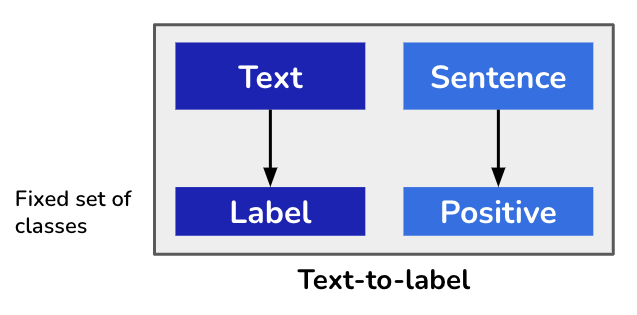

Text-to-label tasks are a core NLP task where the objective is to classify input text to a predefined set of classes. LLMs achieve high accuracy on these with a far lesser data requirement and no model training. In this notebook we will look at how LLM prompts could be designed and evaluated for text-to-label tasks using sentiment analysis as an example. The approach in this notebook can be extended to any other classification task.

We begin by presenting a workflow for prompt design and evaluation for classification tasks.

## Workflow

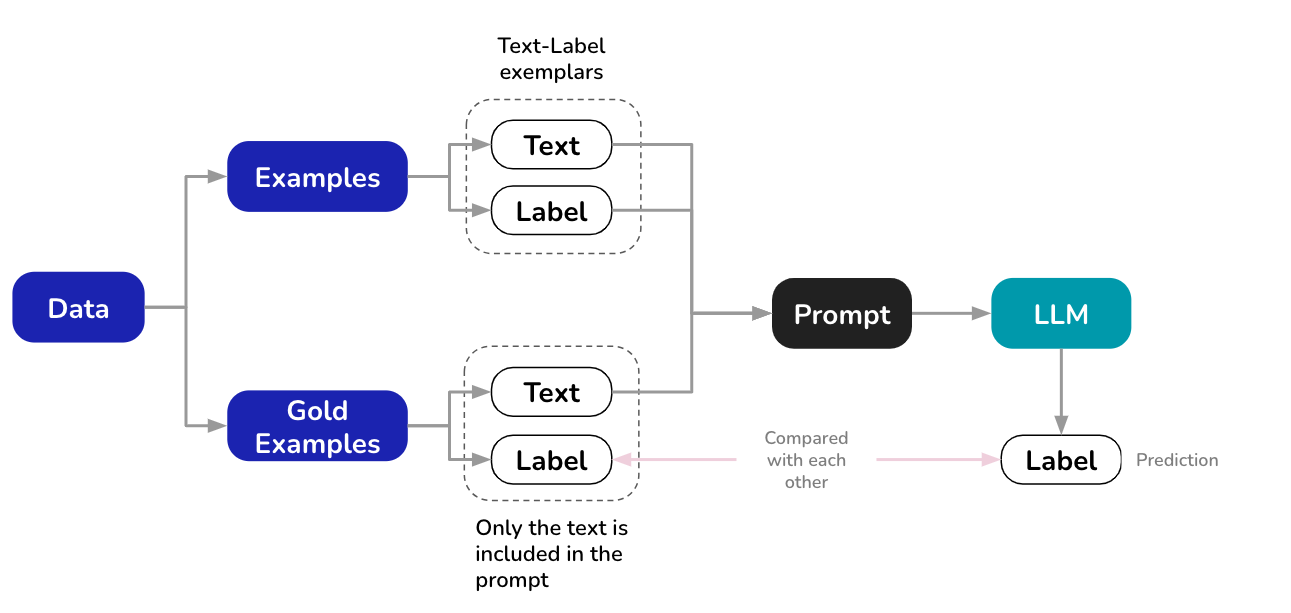

As indicated in the above figure, we do need data to prime the LLM for classification tasks. However, when using LLMs, the requirement on data is several order of magnitudes lesser since there is no training involved. Data used to achieve classification tasks comprises examples and gold examples. Examples are input-output exemplars (usually not more than 8) included in the prompt to prime it for expected label generation. Gold examples are inputs for evaluation where we have ground truth available and predictions from the LLM for the inputs is compared with the ground truths. We choose the best *prompt* as the one that scores high on predefined metrics (e.g., accuracy, F1 score) on the set of gold examples.

Note that we are avoiding the usage of train and test data here to reinforce the idea that there is no model training involved here. While conceptually the idea of examples and gold examples is similar to train and test data, the similarity ends there since there is no model training.

## Evaluation

Performance of prompts for classification tasks can be measured using accuracy, and/or F1 score.

**Accuracy:**

Accuracy measures the proportion of correctly classified instances out of the total number of instances. It is calculated as the number of true positives (correctly classified instances) divided by the total number of instances. Accuracy provides a straightforward measure of a model's overall performance, but it can be misleading if the classes are imbalanced.

**F1 Score:**

The F1 score, also known as the F1 measure or F-score, is a measure of the model's accuracy and precision. It is calculated as the harmonic mean of precision and recall. Precision measures the proportion of true positives among all predicted positive instances, while recall measures the proportion of true positives among all actual positive instances. The F1 score provides a more comprehensive evaluation of a model's performance, as it takes into account both precision and recall.

Let us now implement this workflow for sentiment analysis on a sample of Amazon reviews.

# Business Use Case

Most organizations mandate product managers to constantly monitor product reviews on ecommerce sites such as Amazon to digest user feedback and gain insights into product adoption. Given the volume of reviews that a product team has to deal with, sifting through reviews and flagging those that warrant a response is a human-intensive task that is ripe for automation. In this context, assigning sentiment to product reviews (sentiment analysis) and identifying specific aspects of the product and the associated sentiment (aspect-based sentiment analysis) become critical.

Beyond analysing sentiment attached to a product review, some additional interesting questions that could be answered using LLMs are:
- Features that are liked and disliked the most
- Fraction of reviews that express extreme dissatisfaction
- Whether the product is deemed to be value-for-money?

# Sentiment Analysis

## Prompt Design

We will design a few-shot prompt for sentiment analysis. We first assemble a set of examples (input-output exemplars) as a part of the few-shot prompt. Then we create the prompt in the Azure Open API format.

To evaluate the performance of the *prompt* we will use a set of *gold examples*, that is, a set of examples that is not presented to the model as a part of the prompt.  

**Examples and Gold Examples**

A set of examples and gold examples for sentiment classification of Amazon product reviews is hosted in a HuggingFace dataset. Let us load this data and take a look at the samples in this data.

In [ ]:
amazon_reviews = load_dataset("pgurazada1/amazon_polarity")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

Generating gold_examples split:   0%|          | 0/32 [00:00<?, ? examples/s]

As is evident from the above output, the data set has 32 samples as examples and 32 samples as gold examples.

In [ ]:
amazon_reviews_examples_df = amazon_reviews['examples'].to_pandas()
amazon_reviews_gold_examples_df = amazon_reviews['gold_examples'].to_pandas()

In [ ]:
amazon_reviews_examples_df.shape, amazon_reviews_gold_examples_df.shape

((32, 2), (32, 2))

As the above outputs indicate, there are 32 examples and 32 gold examples. We will sample from the examples to create the few shot prompt and evaluate the prompt on all 32 gold examples.

In [ ]:
amazon_reviews_examples_df.sample(4)

,content,label
24,"Of Course Of course this album was hella ill, ...",1
26,We moved to Budapest and will travel to other ...,0
7,The COPS(Central Command Police Specialists) a...,0
30,Avoid this line of Sony portable CD players - ...,0


**Assembling the prompt**

In [ ]:
system_message = """
Classify product reviews in the input as positive or negative in sentiment.
Do not explain your answer. Your answer should only contain the label: 1 (positive) or 0 (negative).
"""

In [ ]:
few_shot_prompt = [{'role':'system', 'content': system_message}]

We need to iterate over the rows of the examples DataFrame to append these examples as `user` and `assistant` messages to the few-shot prompt. We achieve this using the `iterrows` method.

In [ ]:
for index, row in amazon_reviews_examples_df.iterrows():
    print('Example Review:')
    print(row[0])
    print('Example Label:')
    print(row[1])
    break

Example Review:
i bought three of these and had problems with all three! as another reviewer noted, any time you touch the wire, this thing goes off and i have to manually reset which causes an odd buzzing that i don't like the sound of. i have this under my computer desk and occasionally hit the wire with my feet. a surge protector should be more robust than this and since i have had the same problem with three units ( i bought them all at once or would never repurchase)i don't believe it is a rare defect but built into the design.
Example Label:
0


Notice that the label is an integer. However, LLMs accept only strings. So we need to convert the integer label to a string label as we assemble the few-shot prompt. Let us assemble a few-shot prompt with 4 examples.

In [ ]:
for index, row in amazon_reviews_examples_df.sample(4).iterrows():
    example_review = row[0]
    example_label = row[1]

    few_shot_prompt.append(
        {
            'role': 'user',
            'content': example_review
        }
    )

    few_shot_prompt.append(
        {
            'role': 'assistant',
            'content': str(example_label) # LLMs accept only string inputs
        }
    )

In [ ]:
few_shot_prompt

[{'role': 'system',
  'content': '\nClassify product reviews in the input as positive or negative in sentiment.\nDo not explain your answer. Your answer should only contain the label: 1 (positive) or 0 (negative).\n'},
 {'role': 'user',
  'content': 'The COPS(Central Command Police Specialists) are a group of the best crime fighters in the U.S. led by fed agent V.P. Vess codename Bulletproof which are formed to fight against The Big Boss and his henchmen in Empire City the nation most corrupted and criminilized city.These 3 episodes contained in this disc are the 3 first produced by DIC animation in the 1988 season.The opening credits are omited and only the closing credits are included after the last ep.No special feats are included nor captions or subtitles following the standard in these low budget transfers.The audio and picture quality is good and that is the only good thing in this disc.We deserve more eps and these released in the way of a complete season like G.I. Joe and other

We now have 4 examples in the few shot prompt that is ready for use. Before we deploy this prompt, we need to get an estimate of the performance of this prompt. Here is where we use gold examples to estimate the accuracy.

## Evaluation

In [ ]:
predictions, ground_truths = [], []

In [ ]:
for index, row in tqdm(amazon_reviews_gold_examples_df.iterrows()):
    gold_review = row[0]
    gold_label = row[1]

    user_input = [{'role':'user', 'content': gold_review}]

    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=few_shot_prompt + user_input,
            temperature=0
        )

        predictions.append(int(response.choices[0].message.content)) # convert the string label back to int
        ground_truths.append(gold_label)
    except Exception as e:
        print(e) # Log error and continue
        continue

15it [00:04,  3.62it/s]

Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'high'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}


32it [00:08,  3.56it/s]


In [ ]:
predictions = np.array(predictions)
ground_truths = np.array(ground_truths)
(predictions == ground_truths).mean()

0.9354838709677419

The output above indicates that the accuracy of the few-shot prompt on gold examples. More fine-grained evaluation (e.g., F1 score) could also be used to establish the estimated accuracy of the prompt.

In [ ]:
print(classification_report(ground_truths, predictions))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.87      1.00      0.93        13

    accuracy                           0.94        31
   macro avg       0.93      0.94      0.93        31
weighted avg       0.94      0.94      0.94        31



>More examples does not imply better accuracy. Increasing the number of examples in the few-shot prompt beyond 16 is not known to yield better performance.

# Aspect-Based Sentiment Analysis (ABSA)

So far, we have been concerned with the overall sentiment of the input. However, when there are several aspects ("themes") that are included in the input text, it is not necessary that all the aspects of the input share the same sentiment. For example, when reviewing a mobile phone, a customer might express sentiment about the different features of the phone (e.g., camera, storage, screen, processor) and these features might not share the same sentiment. It is likely that while the customer liked the camera, they expressed concern about the storage on the phone.

In aspect-based sentiment analysis (ABSA), the aim is to identify the aspects of entities and the sentiment expressed for each aspect. The ultimate goal is to be able to generate a measure of polarity that explicitly accounts for the different aspects of the input. In this way, ABSA presents a nuanced version of the overall polarity of the sentiment expresses in the input. For effective ABSA, we should be able to generate appropriate themes and then assign sentiment to the portions of the input that correspond to this theme.

## Prompt Design

We will design a few-shot prompt for ABSA. We first assemble a set of examples (input-output exemplars) as a part of the few-shot prompt. Then we create the prompt in the Anyscale API format.

To evaluate the performance of the *prompt* we will use a set of *gold examples*, that is, a set of examples that is not presented to the model as a part of the prompt.  

**Examples and Gold Examples**

A set of examples and gold examples for aspect-based sentiment classification of restaurant reviews is hosted in a HuggingFace dataset. Let us load this data and take a look at the samples in this data.

In [ ]:
aspect_based_restaurant_reviews_corpus = load_dataset("jakartaresearch/semeval-absa", "restaurant")

Generating train split:   0%|          | 0/3044 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/800 [00:00<?, ? examples/s]

In [ ]:
restaurant_reviews_examples_df = aspect_based_restaurant_reviews_corpus['train'].to_pandas()
restaurant_reviews_gold_examples_df = aspect_based_restaurant_reviews_corpus['validation'].to_pandas()

In [ ]:
examples_json = restaurant_reviews_examples_df.sample(4, random_state=42).to_json(orient='records')
gold_examples_json = restaurant_reviews_gold_examples_df.sample(32, random_state=42).to_json(orient='records')

In [ ]:
json.loads(examples_json)

[{'id': '395',
  'text': 'The sake menu should not be overlooked!',
  'aspects': {'term': ['sake menu'],
   'polarity': ['positive'],
   'from': [4],
   'to': [13]},
  'category': {'category': ['food'], 'polarity': ['positive']}},
 {'id': '527',
  'text': 'Great spot, whether looking for a couple of drinks or quiet dinner.',
  'aspects': {'term': ['drinks', 'dinner', 'spot'],
   'polarity': ['positive', 'positive', 'positive'],
   'from': [44, 60, 6],
   'to': [50, 66, 10]},
  'category': {'category': ['ambience'], 'polarity': ['positive']}},
 {'id': '570',
  'text': 'I was there on sat.',
  'aspects': {'term': [''], 'polarity': [''], 'from': [0], 'to': [0]},
  'category': {'category': ['anecdotes/miscellaneous'],
   'polarity': ['neutral']}},
 {'id': '1203',
  'text': 'I came to this restaurant expecting to be surprised but left bored and overcharged.',
  'aspects': {'term': [''], 'polarity': [''], 'from': [0], 'to': [0]},
  'category': {'category': ['anecdotes/miscellaneous', 'price'

The labels we need are in the category key.

As the above code indicates, we have sampled 4 examples and 32 gold examples for ABSA.

**Assembling the prompt**

In [ ]:
few_shot_system_message = """
Perform aspect based sentiment analysis on restaurant reviews presented in the input delimited by triple backticks, that is, ```.
In each review there might be one or more of the following aspects: food, service, ambience, anecdotes/miscellaneous.
For each review presented as input:
- Identify if there are any of the 4 aspects (food, service, ambience, anecdotes/miscellaneous) present in the review.
- Assign a sentiment polarity (positive, negative or neutral) for each aspect

Arrange your response a JSON object with the following headers:
- category:[list of aspects]
- polarity:[list of corresponding polarities for each aspect]
"""

In [ ]:
few_shot_prompt = [{'role':'system', 'content': few_shot_system_message}]

We need to iterate over the examples to append these examples as `user` and `assistant` messages to the few-shot prompt.

In [ ]:
for example in json.loads(examples_json):
    print(example['text'])
    print('--')
    print(example['category'])
    break

The sake menu should not be overlooked!
--
{'category': ['food'], 'polarity': ['positive']}


Notice that the label is an integer. However, LLMs accept only strings. So we need to convert the integer label to a string label as we assemble the few-shot prompt. Let us assemble a few-shot prompt with 4 examples.

In [ ]:
for example in json.loads(examples_json):
    example_review = example['text']
    example_label = example['category']

    few_shot_prompt.append(
        {
            'role': 'user',
            'content': example_review
        }
    )

    few_shot_prompt.append(
        {
            'role': 'assistant',
            'content': str(example_label)
        }
    )

In [ ]:
few_shot_prompt

[{'role': 'system',
  'content': '\nPerform aspect based sentiment analysis on restaurant reviews presented in the input delimited by triple backticks, that is, ```.\nIn each review there might be one or more of the following aspects: food, service, ambience, anecdotes/miscellaneous.\nFor each review presented as input:\n- Identify if there are any of the 4 aspects (food, service, ambience, anecdotes/miscellaneous) present in the review.\n- Assign a sentiment polarity (positive, negative or neutral) for each aspect\n\nArrange your response a JSON object with the following headers:\n- category:[list of aspects]\n- polarity:[list of corresponding polarities for each aspect]\n'},
 {'role': 'user', 'content': 'The sake menu should not be overlooked!'},
 {'role': 'assistant',
  'content': "{'category': ['food'], 'polarity': ['positive']}"},
 {'role': 'user',
  'content': 'Great spot, whether looking for a couple of drinks or quiet dinner.'},
 {'role': 'assistant',
  'content': "{'category':

We now have 4 examples in the few shot prompt that is ready for use. Before we deploy this prompt, we need to get an estimate of the performance of this prompt. Here is where we use gold examples to estimate the accuracy.

## Evaluation

As in the case of sentiment analysis discussed in the previous task, we assign positive or negative sentiment to a review, with the additional objective of identifying entities (if any) present in the review.

To evaluate model performance, we judge the accuracy of the aspects + sentiment assignnment per aspect. Note that this is a much more stringent measure compared to the sentiment classification task we have seen so far. For example, if aspects identified by the LLM do not match the ground truth for a specific input, we count this prediction to be incorrect. A correct prediction is one where all the aspects are correctly idenfied and further the sentiment assignment for each aspect is also correctly identified (see figure below).

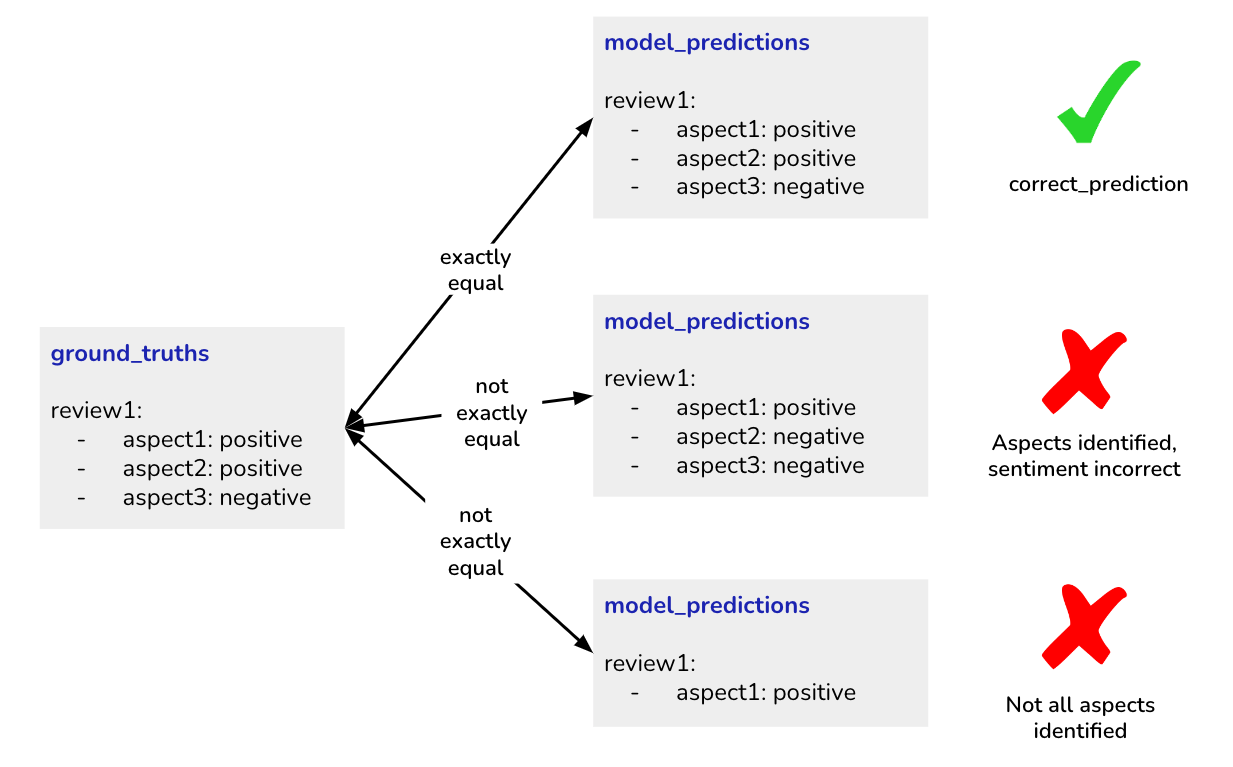

In [ ]:
model_predictions, ground_truths = [], []

In [ ]:
for example in json.loads(gold_examples_json):
    gold_review = example['text']
    gold_label = example['category']

    user_input = [{'role':'user', 'content': gold_review}]

    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=few_shot_prompt + user_input,
            temperature=0
        )

        prediction = response.choices[0].message.content.replace("'", "\"")

        model_predictions.append(json.loads(prediction.strip().lower()))
        ground_truths.append(example['category'])

    except Exception as e:
        print(e) # Log error
        continue

In [ ]:
def compute_accuracy(model_predictions, ground_truths, num_gold_examples=32):

    """
    Return the accuracy score comparing the model predictions and ground truth
    for ABSA. We look for exact matches between the model predictions on all the
    aspects and sentiments for these aspects in the ground truth.

    Args:
        gold_examples (str): JSON string with list of gold examples
        model_predictions (List): Nested list of ABSA predictions
        ground_truths (List): Nested list of ABSA annotations

    Output:
        accuracy (float): Exact matches of model predictions and ground truths
    """
    # Initialize variables to keep track of correct and total predictions
    correct_predictions = 0

    # Iterate through each prediction and ground truth pair
    for pred, truth in zip(model_predictions, ground_truths):
        if pred == truth:
            correct_predictions += 1

    # Calculate accuracy as the ratio of correct predictions to total predictions
    accuracy = correct_predictions / num_gold_examples

    return accuracy

In [ ]:
compute_accuracy(model_predictions, ground_truths)

0.6875